In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
customers = pd.read_csv("../data/cleaned/customers_cleaned.csv")
orders = pd.read_csv("../data/cleaned/orders_cleaned.csv")
order_items = pd.read_csv("../data/cleaned/order_items_cleaned.csv")
payments = pd.read_csv("../data/cleaned/payments_cleaned.csv")


In [3]:
orders_payments = orders.merge(payments , on = "order_id", how = "left")

In [4]:
full_data = orders_payments.merge(customers, on="customer_id", how="left")


In [5]:
full_data = full_data.merge(order_items, on="order_id", how="left")


In [6]:
full_data.shape

(118434, 22)

In [7]:
total_revenue = full_data["payment_value"].sum()
total_orders = full_data["order_id"].nunique()
total_customers = full_data["customer_id"].nunique()

total_revenue, total_orders, total_customers


(20470726.659999996, 99441, 99441)

kpis above


In [9]:
avg_order_value = total_revenue / total_orders
print(avg_order_value)


205.85801289206663


In [10]:
orders["order_status"].value_counts()


order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [11]:
payments["payment_type"].value_counts()


payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [12]:
payments.groupby("payment_type")["payment_value"].sum().sort_values(ascending=False)


payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64

In [13]:
full_data["order_month"] = pd.to_datetime(
    full_data["order_purchase_timestamp"]
).dt.to_period("M")

monthly_revenue = full_data.groupby("order_month")["payment_value"].sum()
monthly_revenue


order_month
2016-09        388.47
2016-10      76120.17
2016-12         19.62
2017-01     189015.66
2017-02     349701.93
2017-03     544738.23
2017-04     510891.55
2017-05     731017.09
2017-06     608891.38
2017-07     744599.53
2017-08     876129.37
2017-09    1023095.49
2017-10    1031505.53
2017-11    1599444.18
2017-12    1057582.34
2018-01    1415348.54
2018-02    1311260.71
2018-03    1480045.50
2018-04    1497843.94
2018-05    1511113.00
2018-06    1298685.81
2018-07    1359421.48
2018-08    1248837.93
2018-09       4439.54
2018-10        589.67
Freq: M, Name: payment_value, dtype: float64

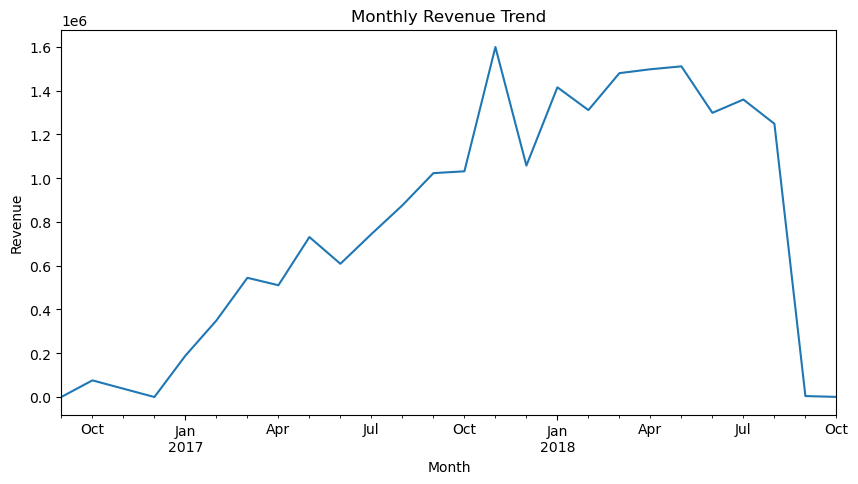

In [14]:
monthly_revenue.plot(figsize=(10,5))
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


In [15]:
full_data["customer_state"].value_counts().head(10)


customer_state
SP    49967
RJ    15420
MG    13738
RS     6521
PR     6017
SC     4328
BA     4071
DF     2489
GO     2443
ES     2347
Name: count, dtype: int64

In [16]:
full_data.groupby("customer_state")["payment_value"].sum().sort_values(ascending=False).head(10)


customer_state
SP    7673188.55
RJ    2783724.26
MG    2341861.47
RS    1152019.17
PR    1074614.19
BA     802416.72
SC     799135.92
GO     516182.51
DF     434512.55
ES     406946.26
Name: payment_value, dtype: float64

In [19]:
full_data["order_purchase_timestamp"] = pd.to_datetime(
    full_data["order_purchase_timestamp"], errors="coerce"
)

full_data["order_delivered_customer_date"] = pd.to_datetime(
    full_data["order_delivered_customer_date"], errors="coerce"
)

full_data["order_estimated_delivery_date"] = pd.to_datetime(
    full_data["order_estimated_delivery_date"], errors="coerce"
)


In [21]:
full_data["delivery_time_days"] = (
    full_data["order_delivered_customer_date"] -
    full_data["order_purchase_timestamp"]
).dt.days

full_data["delivery_time_days"].describe()

count    115037.000000
mean         12.019237
std           9.461440
min           0.000000
25%           6.000000
50%          10.000000
75%          15.000000
max         209.000000
Name: delivery_time_days, dtype: float64

In [23]:
late_orders = full_data[
    full_data["order_delivered_customer_date"] >
    full_data["order_estimated_delivery_date"]
]

late_orders.shape


(9027, 24)

In [25]:
late_percentage = (late_orders["order_id"].nunique() / total_orders) * 100
late_percentage


7.870998883760219

In [27]:
order_items.groupby("product_id")["price"].sum().sort_values(ascending=False).head(10)


product_id
bb50f2e236e5eea0100680137654686c    63885.00
6cdd53843498f92890544667809f1595    54730.20
d6160fb7873f184099d9bc95e30376af    48899.34
d1c427060a0f73f6b889a5c7c61f2ac4    47214.51
99a4788cb24856965c36a24e339b6058    43025.56
3dd2a17168ec895c781a9191c1e95ad7    41082.60
25c38557cf793876c5abdd5931f922db    38907.32
5f504b3a1c75b73d6151be81eb05bdc9    37733.90
53b36df67ebb7c41585e8d54d6772e08    37683.42
aca2eb7d00ea1a7b8ebd4e68314663af    37608.90
Name: price, dtype: float64

In [29]:
os.makedirs("../data/eda_outputs", exist_ok=True)
monthly_revenue.to_csv("../data/eda_outputs/monthly_revenue.csv")


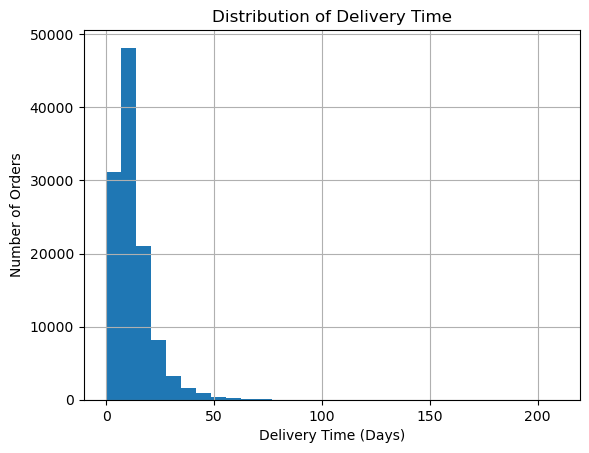

In [31]:
import matplotlib.pyplot as plt

full_data["delivery_time_days"].dropna().hist(bins=30)
plt.xlabel("Delivery Time (Days)")
plt.ylabel("Number of Orders")
plt.title("Distribution of Delivery Time")
plt.show()


In [33]:
delivered = full_data[
    full_data["order_delivered_customer_date"].notna()
].copy()


In [35]:
delivered["is_late"] = (
    delivered["order_delivered_customer_date"] >
    delivered["order_estimated_delivery_date"]
)


In [37]:
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    full_data[col] = pd.to_datetime(full_data[col], errors="coerce")



In [39]:
delivered["is_late"].value_counts(normalize=True) * 100


is_late
False    92.152959
True      7.847041
Name: proportion, dtype: float64

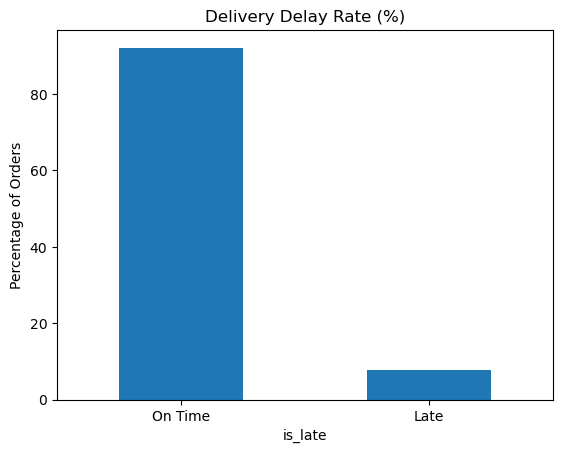

In [41]:
(delivered["is_late"]
 .value_counts(normalize=True)
 .sort_index() * 100
).plot(kind="bar")

plt.xticks([0,1], ["On Time", "Late"], rotation=0)
plt.ylabel("Percentage of Orders")
plt.title("Delivery Delay Rate (%)")
plt.show()


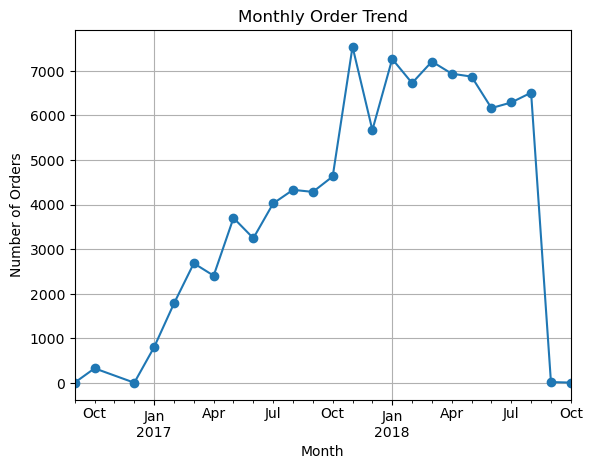

In [45]:
# Monthly order trend
full_data["order_month"] = full_data["order_purchase_timestamp"].dt.to_period("M")

monthly_orders = (
    full_data
    .groupby("order_month")["order_id"]
    .nunique()
    .sort_index()
)

monthly_orders.plot(kind="line", marker="o")
plt.title("Monthly Order Trend")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()



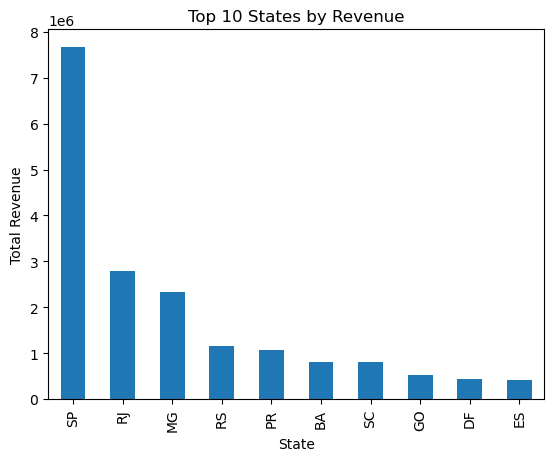

In [47]:
# Top states by total revenue
state_revenue = (
    full_data
    .groupby("customer_state")["payment_value"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

state_revenue.plot(kind="bar")
plt.title("Top 10 States by Revenue")
plt.xlabel("State")
plt.ylabel("Total Revenue")
plt.show()


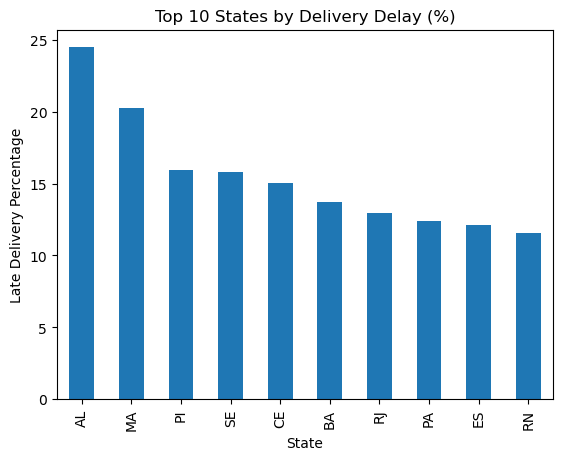

In [49]:
# Delivery delay percentage by state
delay_by_state = (
    delivered
    .groupby("customer_state")["is_late"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
) * 100

delay_by_state.plot(kind="bar")
plt.title("Top 10 States by Delivery Delay (%)")
plt.xlabel("State")
plt.ylabel("Late Delivery Percentage")
plt.show()


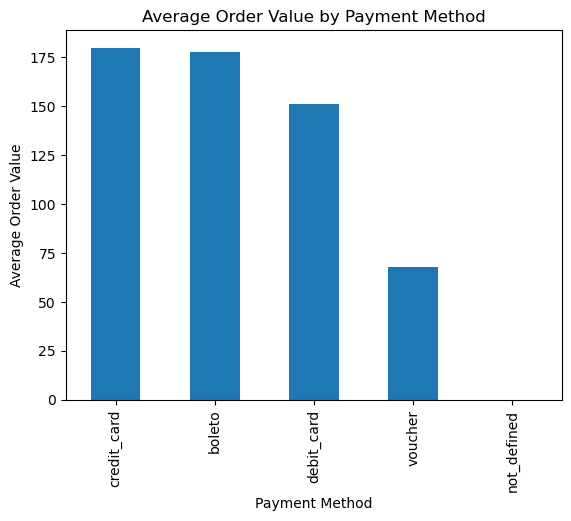

In [51]:
# Average order value by payment method
payment_aov = (
    full_data
    .groupby("payment_type")["payment_value"]
    .mean()
    .sort_values(ascending=False)
)

payment_aov.plot(kind="bar")
plt.title("Average Order Value by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Average Order Value")
plt.show()


In [53]:
full_data.to_csv("../data/cleaned/full_data.csv", index=False)
